# Framework for testing features

In [89]:
#IMPORTS

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from geopy.distance import geodesic
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
ais_train_data_path = '../../Project materials/ais_train.csv'
ais_test_data_path = '../../Project materials/ais_test.csv'
ports_data_path = '../../Project materials/ports.csv'
vessels_data_path = '../../Project materials/vessels.csv'
schedules_data_path = '../../Project materials/schedules_to_may_2024.csv'



ais_data_train = pd.read_csv(ais_train_data_path, sep='|')
ais_data_test = pd.read_csv(ais_test_data_path, sep=',')
ports = pd.read_csv(ports_data_path, sep='|')
vessels = pd.read_csv(vessels_data_path, sep='|')
schedules = pd.read_csv(schedules_data_path, sep='|')

In [91]:
#FILTER OUT ALL SHIPS WITH LESS THAN 300 ENTRIES FROM THE TRAINING DATAFRAME:

timesteps_per_ship = ais_data_train.groupby('vesselId').size()
vessels_with_enough_timesteps = timesteps_per_ship[timesteps_per_ship >= 300].index

# Step 3: Filter the main dataframe to keep only ships with 300 or more timesteps
ais_data_train = ais_data_train[ais_data_train['vesselId'].isin(vessels_with_enough_timesteps)]


### Create or extract features that are to be tested:

##### Movement status

In [92]:
# EXTRACT MOVEMENT STATUS FROM NAVSTAT:

def categorize_navstat_contrast(navstat):
    if navstat in [0, 8]:
        return 1  # Underway
    elif navstat in [2, 3, 4]:
        return 0.5  # Restricted Movement
    elif navstat in [1, 5, 6]:
        return -1  # Stationary
    else:
        return 0  # Unknown

ais_data_train['movement_status'] = ais_data_train['navstat'].apply(categorize_navstat_contrast)


##### Estimated time to destination

In [93]:
#Preprocess ETA RAW and time

current_year = 2024
ais_data_train['ETARAW_transformed'] = ais_data_train['etaRaw'].apply(lambda x: f"{current_year}-{x}")
ais_data_train['ETARAW_transformed'] = pd.to_datetime(ais_data_train['ETARAW_transformed'], format='%Y-%m-%d %H:%M', errors='coerce')
ais_data_train['time'] = pd.to_datetime(ais_data_train['time'])

In [94]:
# Use linear interpolation to edit nan values

ais_data_train =ais_data_train.sort_values(by=['vesselId', 'time']).reset_index(drop=True)
grouped =ais_data_train.groupby('vesselId')
ais_data_train['ETARAW_transformed'] = grouped['ETARAW_transformed'].apply(lambda x: x.interpolate(method='linear')).reset_index(level=0, drop=True)

ais_data_train['estimated_time_to_destination'] = (ais_data_train['ETARAW_transformed'] -ais_data_train['time']).dt.total_seconds() / 3600

##### Time difference

In [95]:
ais_data_train['time_difference'] = ais_data_train.groupby('vesselId')['time'].diff().dt.total_seconds() / 60
ais_data_train['time_difference'] = ais_data_train['time_difference'].fillna(0)


### Split the dataset into testing and training sets

In [96]:
def split_ship_dataset(ship_dataset):

    last_timestep = ship_dataset['time'].max()
    five_days_ago = last_timestep - pd.Timedelta(days=5)

    test_data = ship_dataset[ship_dataset['time'] > five_days_ago]
    train_data = ship_dataset[ship_dataset['time'] <= five_days_ago]

    return train_data, test_data

In [97]:
ais_data_train = ais_data_train.sort_values(by=['vesselId', 'time'])

train_list = []
test_list = []

for vessel_id, group in ais_data_train.groupby('vesselId'):
    train_data, test_data = split_ship_dataset(group)
    train_list.append(train_data)
    test_list.append(test_data)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)


In [98]:
print(train_df.shape)
print(test_df.shape)

(1435417, 15)
(85622, 15)


## Testing the one model per ship approach (Random Forest)

Try:
- Implement a random forest classifier for the movement status feature (Transform features between the numeric values to the labels)

In [99]:
baseline_features = ['longitude', 'latitude', 'time_difference']
new_features = ['longitude', 'latitude', 'time_difference', 'cog', 'sog']

unique_vessel_ids = ais_data_test['vesselId'].unique()

sequence_length = 5
number_of_estimatiors = 50
random_state = 42


longitude_number_of_estimatiors = 50
longitude_bootstrap = False
longitude_max_depth = 6
longitude_min_samples_leaf = 4
longitude_min_samples_split = 2

latitude_number_of_estimatiors = 200
latitude_bootstrap = True
latitude_max_depth = 25
latitude_min_samples_leaf = 4
latitude_min_samples_split = 2

cog_number_of_estimatiors = 100
cog_bootstrap = True
cog_max_depth = 6
cog_min_samples_leaf = 2
cog_min_samples_split = 2

sog_number_of_estimatiors = 250
sog_bootstrap = True
sog_max_depth = 6
sog_min_samples_leaf = 4
sog_min_samples_split = 2






In [100]:
baseline_geodesic_distances = []
new_geodesic_distances = []

movement_status_mismatch_count = 0  
total_movement_status_count = 0

feature_importances_lat = []
feature_importances_lon = []

In [101]:

for vessel_id in unique_vessel_ids:

    # EXTRACT DATA FOR THE VESSEL AT HAND:
    vessel_df_train = train_df[train_df['vesselId'] == vessel_id]
    vessel_df_test = test_df[test_df['vesselId'] == vessel_id]

    vessel_df_train = vessel_df_train.sort_values(by='time')
    vessel_df_test = vessel_df_test.sort_values(by='time')
    vessel_df_test = vessel_df_test.reset_index(drop=True)

    if len(vessel_df_train) < sequence_length:
        print(f'Not enough historical data to predict for vessel_id: {vessel_id}')
        continue

    total_new_features = vessel_df_train[new_features].values  

    # CREATE TIMESERIES:
    X_baseline, y_baseline, X_new, y_new = [], [], [], []
    for i in range(len(total_new_features) - sequence_length):
        X_new.append(total_new_features[i:i + sequence_length])

        y_new.append(total_new_features[i + sequence_length])

    X_new = np.array(X_new)

    y_new = np.array(y_new)

    # DEFINE MODELS:
    # lat_new_model = RandomForestRegressor(n_estimators=latitude_number_of_estimatiors, max_depth=latitude_max_depth, min_samples_split=latitude_min_samples_split, min_samples_leaf=latitude_min_samples_leaf, bootstrap=latitude_bootstrap, random_state=random_state)
    # lon_new_model = RandomForestRegressor(n_estimators=longitude_number_of_estimatiors, max_depth=longitude_max_depth, min_samples_split=longitude_min_samples_split, min_samples_leaf=longitude_min_samples_leaf, bootstrap=longitude_bootstrap, random_state=random_state)
    # cog_new_model = RandomForestRegressor(n_estimators=cog_number_of_estimatiors, max_depth=cog_max_depth, min_samples_split=cog_min_samples_split, min_samples_leaf=cog_min_samples_leaf, bootstrap=cog_bootstrap, random_state=random_state)
    # sog_new_model = RandomForestRegressor(n_estimators=sog_number_of_estimatiors, max_depth=sog_max_depth, min_samples_split=sog_min_samples_split, min_samples_leaf=sog_min_samples_leaf, bootstrap=sog_bootstrap, random_state=random_state)

    lat_new_model = RandomForestRegressor(n_estimators=number_of_estimatiors, random_state=random_state)
    lon_new_model = RandomForestRegressor(n_estimators=number_of_estimatiors, random_state=random_state)
    cog_new_model = RandomForestRegressor(n_estimators=number_of_estimatiors, random_state=random_state)
    sog_new_model = RandomForestRegressor(n_estimators=number_of_estimatiors, random_state=random_state)
    


    # TRAIN MODELS:
    lat_new_model.fit(X_new.reshape(X_new.shape[0], -1), y_new[:, 1])
    lon_new_model.fit(X_new.reshape(X_new.shape[0], -1), y_new[:, 0])
    cog_new_model.fit(X_new.reshape(X_new.shape[0], -1), y_new[:, 3])
    sog_new_model.fit(X_new.reshape(X_new.shape[0], -1), y_new[:, 4])


    #EXTRACT FEATURE IMPORTANCE
    feature_importances_lat.append(lat_new_model.feature_importances_)
    feature_importances_lon.append(lon_new_model.feature_importances_)


    # PREPARE FOR EVALUATION OF MODELS:
    last_known_sequence_new = total_new_features[-sequence_length:] 

    current_input_new = last_known_sequence_new.reshape(1, -1)

    true_latitudes = vessel_df_test[baseline_features].iloc[:, 1]
    true_longitudes = vessel_df_test[baseline_features].iloc[:, 0]

    for step in range(len(vessel_df_test)):

        # PREDICTIONS:
        predicted_lat_new = lat_new_model.predict(current_input_new)[0]
        predicted_lon_new = lon_new_model.predict(current_input_new)[0]
        predicted_cog_new = cog_new_model.predict(current_input_new)[0]
        predicted_sog_new = sog_new_model.predict(current_input_new)[0]

        # EVALUATION:
        true_lat = true_latitudes[step]
        true_lon = true_longitudes[step]

        actual_coords = (true_lat, true_lon)


        new_predicted_coords = (predicted_lat_new, predicted_lon_new)
        geodesic_dist_new = geodesic(actual_coords, new_predicted_coords).kilometers
        new_geodesic_distances.append(geodesic_dist_new)


        # FIND NEXT INPUTS:

        next_input_new = np.array([predicted_lon_new, predicted_lat_new, 20, predicted_cog_new, predicted_sog_new])  
        
        current_input_new = np.hstack([current_input_new[:, 5:], next_input_new.reshape(1, -1)])
        
    print("Done with a ship")

average_geodesic_new = np.mean(new_geodesic_distances)

# VISUALIZE RESULTS
print(f"New Model - Average Geodesic Distance (km): {average_geodesic_new}")


Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a ship
Done with a sh

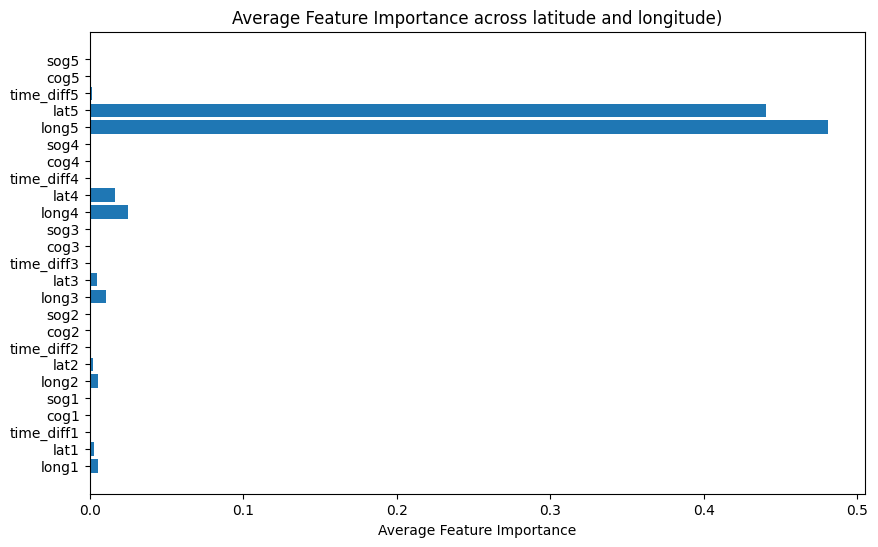

In [103]:
#VISUALIZE FEATURE IMPORTANCE

features = ['long1', 'lat1', 'time_diff1', 'cog1', 'sog1', 'long2', 'lat2','time_diff2', 'cog2', 'sog2', 'long3', 'lat3', 'time_diff3', 'cog3', 'sog3', 'long4', 'lat4', 'time_diff4', 'cog4', 'sog4', 'long5', 'lat5', 'time_diff5', 'cog5', 'sog5']

feature_importances_lat = np.array(feature_importances_lat)
feature_importances_lon = np.array(feature_importances_lon)

avg_feature_importances_lat = np.mean(feature_importances_lat, axis=0)
avg_feature_importances_lon = np.mean(feature_importances_lon, axis=0)


average_feature_importances = np.mean([avg_feature_importances_lat, avg_feature_importances_lon], axis=0)

plt.figure(figsize=(10, 6))
plt.barh(features, average_feature_importances)
plt.xlabel("Average Feature Importance")
plt.title("Average Feature Importance across latitude and longitude)")
plt.show()

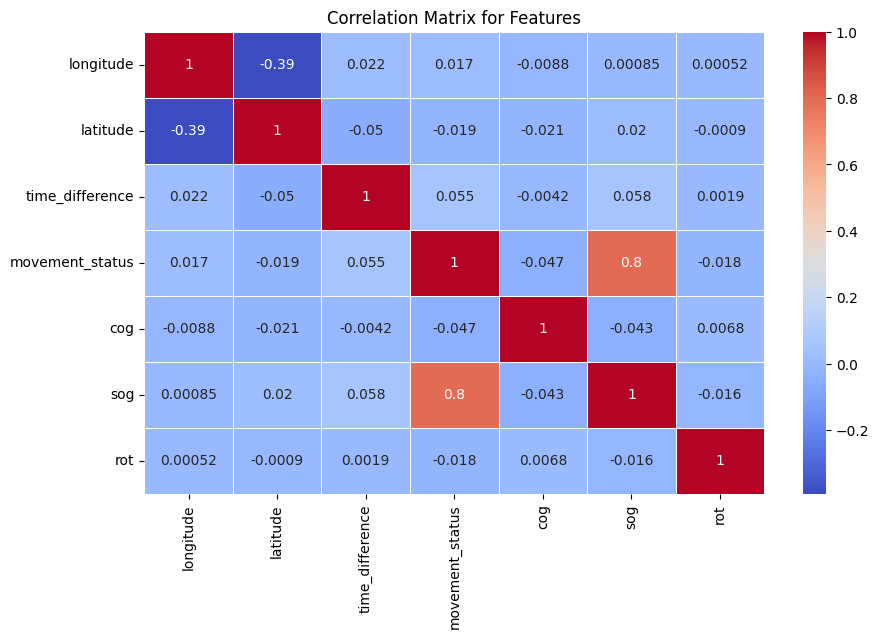

In [59]:
relevant_features = ['longitude', 'latitude', 'time_difference', 'movement_status', 'cog', 'sog', 'rot']

# Create a dataframe with these features
correlation_df = train_df[relevant_features]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Display the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix for Features")
plt.show()